In [342]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
from torch import nn,optim,utils
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import gc

filterwarnings(action='ignore')

gc.collect()

81565

In [343]:
device='cuda' if torch.cuda.is_available() else 'cpu'   

In [344]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

### Forward Process

In [345]:
def find_alpha_bar(t_size,variance_type='linear'):
    if t_size==1:
        
        return [1.]
    
    alpha_bar=torch.zeros(t_size)
    epsilon=1e-5
    
    if variance_type=='linear':
        beta = torch.linspace(0.+epsilon,1.-epsilon,t_size)
        alpha=1-beta
        
        for i,a in enumerate(alpha):
            if i==0:
                alpha_bar[i]=a
            else:
                alpha_bar[i]=alpha_bar[i-1]*a    
    elif variance_type=='cosine':
        coeff=1/t_size
        s=(1e-3)*8
        f=torch.zeros(t_size)
        for i in range(t_size):
            f[i]=torch.cos(torch.tensor((coeff*(i+1)+s)/(1+s)*(np.pi/2)))**2
            alpha_bar[i]=f[i]/f[0]
    
    return torch.tensor(alpha_bar).to(device)

In [346]:
def add_step_noise(origin_image,alpha_bar,step,norm_sample):
    noise_image=torch.sqrt(alpha_bar[step])*origin_image + torch.sqrt(1-alpha_bar[step])*norm_sample
    noise_image[noise_image<0.0]=0.0
    noise_image[noise_image>1.0]=1.0
    
    return noise_image

In [347]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [348]:
mean = 0.0
std_dev = 1.0

size = (images[0].shape) 

samples = torch.normal(mean, std_dev, size=size).to(device)

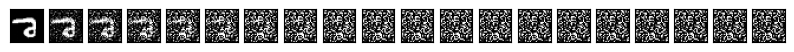

In [349]:
# Linear 
variance_type='linear'
step_num=20
origin_image=images[0].to(device)
alpha_bar=find_alpha_bar(step_num,variance_type)

fig, axs = plt.subplots(1, step_num, figsize=(10, 10))

for i in range(step_num):
    axs[i].imshow(add_step_noise(origin_image,alpha_bar,i,samples).T.cpu().numpy(),cmap='gray')
    axs[i].set_xticks([])  
    axs[i].set_yticks([])

plt.show()

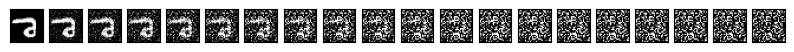

In [350]:
# Cosine
variance_type='cosine'
step_num=20
origin_image=images[0].to(device)
alpha_bar=find_alpha_bar(step_num,variance_type)

fig, axs = plt.subplots(1, step_num, figsize=(10, 10))

for i in range(step_num):
    axs[i].imshow(add_step_noise(origin_image,alpha_bar,i,samples).T.cpu().numpy(),cmap='gray')
    axs[i].set_xticks([])  
    axs[i].set_yticks([])

plt.show()

### Reverse Process with DDPM

In [351]:
class Unet(nn.Module):
    def __init__(self):
        
        super(Unet,self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=1,out_channels=4,kernel_size=(3,3),stride=2, padding=1)
        self.batchnorm1=nn.BatchNorm2d(4)
        self.conv2=nn.Conv2d(in_channels=4,out_channels=8,kernel_size=(3,3),stride=2,padding=1)
        self.batchnorm2=nn.BatchNorm2d(8)

        self.relu = nn.ReLU()
        
        self.linear1=nn.Linear(8*7*7,512)
        self.linear2=nn.Linear(512,8*7*7)
        
        self.conv3=nn.ConvTranspose2d(in_channels=8,out_channels=4,kernel_size=(3,3),stride=2,output_padding=1, padding=1)
        self.batchnorm3=nn.BatchNorm2d(4)
        self.conv4=nn.ConvTranspose2d(in_channels=4,out_channels=1,kernel_size=(3,3),stride=2,output_padding=1, padding=1)
        
        self.sigmoid=nn.Sigmoid()


    def forward(self,x_t,t):

        x_t *= t
        
        x_t = self.batchnorm1(self.relu(self.conv1(x_t)))
        x_t = self.batchnorm2(self.relu(self.conv2(x_t)))
        x_t=x_t.view(-1,8*7*7)
        
        x_t=self.relu(self.linear1(x_t))
        x_t=self.relu(self.linear2(x_t))
        
        x_t = x_t.view(-1,8,7,7)
        x_t = self.batchnorm3(self.relu(self.conv3(x_t)))
        x_t = self.conv4(x_t)
        
        return self.sigmoid(x_t)

In [352]:
def prev_step(x_t,t,alpha_bar,e):

    return (1./torch.sqrt(alpha_bar[t]))*(x_t-(torch.sqrt(1-alpha_bar[t])*e))

In [353]:
def train(images,noise_model,forward_step,variance_type,num_epoch,loss_func,optimizer):

    alpha_bar=find_alpha_bar(t_size=forward_step,variance_type=variance_type)
   
    for epoch in range(num_epoch):
        total_loss=0
        for batch_idx,(img,label) in enumerate(images):
            if batch_idx>10:
                break
            img=img.to(device)
            
            for j in range(len(img)):
             #   print(img[j].shape)
                forwarded_images=torch.zeros((forward_step,len(img),img[j].shape[0],img[j].shape[1],img[j].shape[2]))
                for i in range(forward_step):
                    forwarded_images[i][j]=add_step_noise(img[j],alpha_bar,i,samples)
            for i in range(forward_step):
                    if i!=forward_step-1:
              #          print(forwarded_images[forward_step-i-1].shape)
                        noise_step=noise_model(forwarded_images[forward_step-i-1].to(device),forward_step-i-1)
                        x_prev=prev_step(forwarded_images[forward_step-i-1].to(device),forward_step-i-1,alpha_bar,noise_step)
                        loss=loss_func(x_prev.to(device),forwarded_images[forward_step-i-2].to(device))
                        optimizer.zero_grad()
                        loss.backward()
            
                        optimizer.step()
                        
                        total_loss=loss.item()
                        torch.nn.utils.clip_grad_norm_(noise_model.parameters(), 1.0)
                        if batch_idx==10:
                            print('Epoch: {} last loss: {:.4f}'.format(epoch+1,total_loss))
        total_loss=0.0
    return

In [354]:
noise_model=Unet()
noise_model.to(device)

Unet(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (linear1): Linear(in_features=392, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=392, bias=True)
  (conv3): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (batchnorm3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (sigmoid): Sigmoid()
)

In [355]:
loss_func = nn.MSELoss()
adam = optim.Adam(noise_model.parameters())
num_epoch=20
forward_step=torch.tensor(30)
variance_type='cosine'

In [356]:
train(trainloader,noise_model.to(device),forward_step.to(device),variance_type,num_epoch,loss_func,adam)

Epoch: 1 last loss: 113211034566656.0000
Epoch: 1 last loss: 79.7183
Epoch: 1 last loss: 19.7605
Epoch: 1 last loss: 8.6814
Epoch: 1 last loss: 4.8116
Epoch: 1 last loss: 3.0238
Epoch: 1 last loss: 2.0544
Epoch: 1 last loss: 1.4710
Epoch: 1 last loss: 1.0930
Epoch: 1 last loss: 0.8344
Epoch: 1 last loss: 0.6499
Epoch: 1 last loss: 0.5138
Epoch: 1 last loss: 0.4107
Epoch: 1 last loss: 0.3307
Epoch: 1 last loss: 0.2677
Epoch: 1 last loss: 0.2172
Epoch: 1 last loss: 0.1763
Epoch: 1 last loss: 0.1427
Epoch: 1 last loss: 0.1150
Epoch: 1 last loss: 0.0920
Epoch: 1 last loss: 0.0729
Epoch: 1 last loss: 0.0568
Epoch: 1 last loss: 0.0435
Epoch: 1 last loss: 0.0323
Epoch: 1 last loss: 0.0232
Epoch: 1 last loss: 0.0157
Epoch: 1 last loss: 0.0098
Epoch: 1 last loss: 0.0053
Epoch: 1 last loss: 0.0021
Epoch: 2 last loss: 88938236608512.0000
Epoch: 2 last loss: 62.4568
Epoch: 2 last loss: 15.4521
Epoch: 2 last loss: 6.7801
Epoch: 2 last loss: 3.7551
Epoch: 2 last loss: 2.3591
Epoch: 2 last loss: 1.60

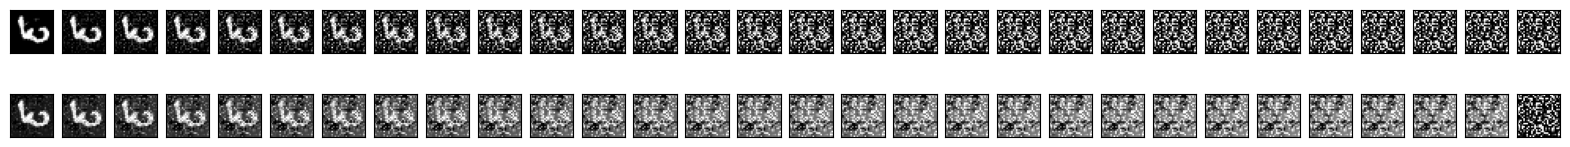

In [357]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

variance_type='cosine'
step_num=30
origin_image=images[0].to(device)
alpha_bar=find_alpha_bar(step_num,variance_type)

fig, axs = plt.subplots(2, step_num, figsize=(20, 2))

ns=torch.zeros(step_num,images[0].shape[0],images[0].shape[1],images[0].shape[2])

for i in range(step_num):
    ns[i]=add_step_noise(origin_image,alpha_bar,i,samples)
    axs[0][i].imshow(ns[i].T.cpu().numpy(),cmap='gray')
    axs[0][i].set_xticks([])  
    axs[0][i].set_yticks([])
for i in range(step_num):
    if i==0:
        axs[1][step_num-i-1].imshow(ns[step_num-i-1].T.cpu().numpy(),cmap='gray')
        axs[1][step_num-i-1].set_xticks([])  
        axs[1][step_num-i-1].set_yticks([])
    else:
        noise_step=noise_model(torch.unsqueeze(ns[step_num-i],dim=0).to(device),step_num-i)
        x_prev=prev_step(ns[step_num-i].to(device),step_num-i,alpha_bar,noise_step)
        
        axs[1][step_num-i-1].imshow(x_prev[0].T.cpu().detach().numpy(),cmap='gray')
        axs[1][step_num-i-1].set_xticks([])  
        axs[1][step_num-i-1].set_yticks([])
        
plt.show()